In [15]:
import pandas as pd             ## To work with the dataset
import numpy as np              ## Linear Algebra and other stuff

import matplotlib.pyplot as plt ## Visualization

import warnings                 ## Don't like these
warnings.filterwarnings('ignore')
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text  import TfidfVectorizer


In [16]:
## Import the Dataset
df = pd.read_excel("Final_Data.xlsx")
df.head()

,Policy,Classification,Summary
0,You agree to grant and hereby grant Zoom a per...,Negative,"Zoom can use your data for anything it wants, ..."
1,You are solely responsible for compliance with...,Positive,Zoom cannot sell your data to other companies ...
2,We use Information we collect to provide a per...,Negative,Human employees can read your personal informa...
3,We may terminate your access to and use of th...,Negative,Figma can shut down your account and delete al...
4,We and our partners store or access informatio...,Negative,This website and its partners can store and ac...


In [17]:
df['Classification'].value_counts()

Classification
Positive    420
Negative    256
Name: count, dtype: int64

In [3]:
df.shape

(676, 3)

In [4]:
## Convert alphabets
df['Policy'] = df['Policy'].apply(lambda x : x.lower())

In [5]:
## Word tokenization
df['Policy'] = df['Policy'].apply(word_tokenize)

In [6]:
## Removing stopwords

StopWords = set(stopwords.words('english'))

def clean_words(x):
    words = []
    for i in x:
        if i.isalnum() and i not in StopWords:
            words.append(i)
    return words

df.loc[:,'Policy'] = df['Policy'].apply(clean_words)

In [7]:
## Lemmatization
lemmatizer = WordNetLemmatizer()

def lemma(l):
    ans = set()
    for word in l:
        ans.add(lemmatizer.lemmatize(word))
    return ans
df['Policy'] = df['Policy'].apply(lambda x : lemma(x))

In [8]:
## Filtering alphabet-words

def get_alpha(x):
    l = []
    for i in x:
        if i.isalpha():
            l.append(i)
    return l

df['Policy'] = df['Policy'].apply(get_alpha)

In [9]:
## For tf-idf representation
df['Policy_TF'] = df['Policy'].apply(lambda x : " ".join(i for i in x))

In [10]:
df['Classification'].value_counts()

Classification
Positive    420
Negative    256
Name: count, dtype: int64

In [11]:
most_common = dict()

for group, data in df.groupby(by='Classification'):
    words = []
    for sent in data['Policy_TF']:
        words.extend(sent.split())
    words = nltk.FreqDist(words)
    words = words.most_common(10)
    most_common['{}'.format(group)] = words
pd.DataFrame(most_common)

,Negative,Positive
0,"(information, 161)","(information, 189)"
1,"(may, 134)","(personal, 156)"
2,"(service, 116)","(service, 153)"
3,"(use, 113)","(may, 142)"
4,"(personal, 73)","(data, 137)"
5,"(u, 64)","(use, 136)"
6,"(data, 60)","(u, 82)"
7,"(including, 59)","(provide, 78)"
8,"(collect, 57)","(collect, 62)"
9,"(also, 54)","(access, 61)"


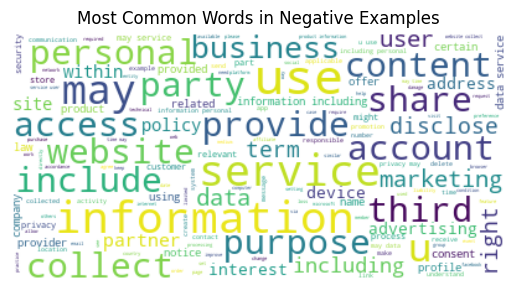

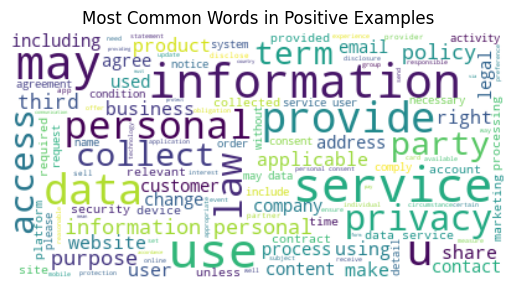

In [14]:



for group, data in df.groupby(by='Classification'):
    words = []
    for sent in data['Policy_TF']:
        words.extend(sent.split())
    text = ' '.join(words)
    wordcloud = WordCloud(max_font_size=40, background_color ='white', stopwords = set(STOPWORDS)).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Common Words in {group} Examples")
    plt.savefig(f"{group}_WordCloud", bbox_inches='tight')
    plt.show()

In [151]:
most_common = dict()

for group, data in df.groupby(by='Classification'):
    words = []
    for sent in data['Policy_TF']:
        words.extend(nltk.bigrams(sent.split()))
    words = nltk.FreqDist(words)
    words = words.most_common(10)
    most_common['{}'.format(group)] = words
pd.DataFrame(most_common)

,Negative,Positive
0,"((service, information), 69)","((service, information), 53)"
1,"((use, may), 52)","((data, service), 45)"
2,"((data, service), 26)","((information, personal), 40)"
3,"((information, personal), 18)","((use, may), 38)"
4,"((information, third), 15)","((personal, use), 18)"
5,"((information, marketing), 15)","((party, data), 16)"
6,"((party, data), 14)","((applicable, law), 16)"
7,"((service, third), 13)","((data, information), 15)"
8,"((data, information), 9)","((information, third), 12)"
9,"((information, policy), 8)","((data, processing), 12)"


## Random Oversampling

In [152]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)

X = df['Policy_TF']
y = df['Classification']
# x_, y_ = ros.fit_resample(X, y)

# x_ = x_['ABS_TF']
# print(y_.value_counts())
# x_['Label'] = y_
# x_.head()
# x_, y_ = x_['Policy_TF'], x_['Label']

In [153]:
y = y.map({'Negative' : 1, 'Positive' : 0})
# y_ = y_.map({'Negative' : 1, 'Positive' : 0})

In [154]:

tf = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 3))
tf.fit(X)
# tf.fit(x_)

## Train-Dev Set.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)
# x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size = 0.2, stratify = y_, random_state = 1)

## Tf-IDF Transformation
tf_x_train = tf.transform(x_train)
tf_x_test = tf.transform(x_test)

## Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
performance = {'Model' : [],
              'Accuracy Score' : [],
              'Precision Score' : [],
              'Recall Score' : [],
              'f1 Score' : []}

### Will try different classification techniques and choose the one that performs best

In [155]:
## Logistic Regression
from sklearn.linear_model import LogisticRegression

lr= LogisticRegression()
lr.fit(tf_x_train, y_train)
pred = lr.predict(tf_x_test)

performance['Model'].append('LogisticRegression')
performance['Accuracy Score'].append(accuracy_score(y_test, pred))
performance['Precision Score'].append(precision_score(y_test, pred, average='macro'))
performance['Recall Score'].append(recall_score(y_test, pred, average='macro'))
performance['f1 Score'].append(f1_score(y_test, pred, average='macro'))

In [156]:
## Support Vector Classifier
from sklearn.svm import SVC

svc = SVC()
svc.fit(tf_x_train, y_train)
pred = svc.predict(tf_x_test)

performance['Model'].append('SVC')
performance['Accuracy Score'].append(accuracy_score(y_test, pred))
performance['Precision Score'].append(precision_score(y_test, pred, average='macro'))
performance['Recall Score'].append(recall_score(y_test, pred, average='macro'))
performance['f1 Score'].append(f1_score(y_test, pred, average='macro'))

In [157]:
## Ensemble learning: Random Forest with default parameters
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(tf_x_train, y_train)
pred = rfc.predict(tf_x_test)

performance['Model'].append('Random Forest')
performance['Accuracy Score'].append(accuracy_score(y_test, pred))
performance['Precision Score'].append(precision_score(y_test, pred, average='macro'))
performance['Recall Score'].append(recall_score(y_test, pred, average='macro'))
performance['f1 Score'].append(f1_score(y_test, pred, average='macro'))

In [158]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=42)
abc.fit(tf_x_train, y_train)
pred = abc.predict(tf_x_test)

performance['Model'].append('ADABoost')
performance['Accuracy Score'].append(accuracy_score(y_test, pred))
performance['Precision Score'].append(precision_score(y_test, pred, average='macro'))
performance['Recall Score'].append(recall_score(y_test, pred, average='macro'))
performance['f1 Score'].append(f1_score(y_test, pred, average='macro'))

In [159]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators=300,learning_rate=0.5)
xgbc.fit(tf_x_train, y_train)
pred = xgbc.predict(tf_x_test)

performance['Model'].append('XGBoost')
performance['Accuracy Score'].append(accuracy_score(y_test, pred))
performance['Precision Score'].append(precision_score(y_test, pred, average='macro'))
performance['Recall Score'].append(recall_score(y_test, pred, average='macro'))
performance['f1 Score'].append(f1_score(y_test, pred, average='macro'))

In [160]:
pd.DataFrame(performance)

,Model,Accuracy Score,Precision Score,Recall Score,f1 Score
0,LogisticRegression,0.635714,0.816547,0.509615,0.406533
1,SVC,0.635714,0.650852,0.513549,0.423030
2,Random Forest,0.650000,0.657761,0.540647,0.486489
3,ADABoost,0.657143,0.624355,0.605332,0.607018
4,XGBoost,0.592857,0.559655,0.558129,0.558604


In [161]:
# lr.predict(tf.transform(x_test))

## Hyperparameter tuning

In [162]:
from sklearn.model_selection import GridSearchCV

In [163]:
# Define the RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # You can adjust the values
    'max_depth': [None, 10, 20, 30],  # You can adjust the values
    'min_samples_split': [2, 5, 10],  # You can adjust the values
    'min_samples_leaf': [1, 2, 4],  # You can adjust the values
}

# Initialize GridSearchCV
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(tf_x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final RandomForestClassifier
best_rfc = RandomForestClassifier(random_state=42, **best_params)

# Fit the final model on the training data
best_rfc.fit(tf_x_train, y_train)

# Make predictions
pred = best_rfc.predict(tf_x_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')
f1 = f1_score(y_test, pred, average='macro')

# Update your performance dictionary
performance['Model'].append('RandomForest_Hyperparameter_Tuned')
performance['Accuracy Score'].append(accuracy)
performance['Precision Score'].append(precision)
performance['Recall Score'].append(recall)
performance['f1 Score'].append(f1)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [164]:
# Define the Support Vector Machine (SVM) classifier
svm = SVC()

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10],               # Regularization parameter
    'kernel': ['linear', 'rbf'],     # Kernel type
    'gamma': ['scale', 'auto', 0.1], # Kernel coefficient
}

# Initialize GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(tf_x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final SVM classifier
best_svm = SVC(**best_params)

# Fit the final model on the training data
best_svm.fit(tf_x_train, y_train)

# Make predictions
pred = best_svm.predict(tf_x_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')
f1 = f1_score(y_test, pred, average='macro')

# Update your performance dictionary
performance['Model'].append('SVM_Hyperparameter_Tuned')
performance['Accuracy Score'].append(accuracy)
performance['Precision Score'].append(precision)
performance['Recall Score'].append(recall)
performance['f1 Score'].append(f1)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [165]:
# Define the AdaBoostClassifier
abc = AdaBoostClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # You can adjust the values
    'learning_rate': [0.001, 0.01, 0.1, 0.5],  # You can adjust the values
}

# Initialize GridSearchCV
grid_search = GridSearchCV(abc, param_grid, cv=5, scoring='f1')

# Fit the grid search to your data
grid_search.fit(tf_x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final AdaBoostClassifier
best_abc = AdaBoostClassifier(random_state=42, **best_params)

# Fit the final model on the training data
best_abc.fit(tf_x_train, y_train)

# Make predictions
pred = best_abc.predict(tf_x_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')
f1 = f1_score(y_test, pred, average='macro')

# Update your performance dictionary
performance['Model'].append('ADABoost_Hyperparameter_Tuned')
performance['Accuracy Score'].append(accuracy)
performance['Precision Score'].append(precision)
performance['Recall Score'].append(recall)
performance['f1 Score'].append(f1)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 200}


In [166]:
pd.DataFrame(performance)

,Model,Accuracy Score,Precision Score,Recall Score,f1 Score
0,LogisticRegression,0.635714,0.816547,0.509615,0.406533
1,SVC,0.635714,0.650852,0.513549,0.423030
2,Random Forest,0.650000,0.657761,0.540647,0.486489
3,ADABoost,0.657143,0.624355,0.605332,0.607018
4,XGBoost,0.592857,0.559655,0.558129,0.558604
5,RandomForest_Hyperparameter_Tuned,0.642857,0.611111,0.542832,0.504390
6,SVM_Hyperparameter_Tuned,0.678571,0.659948,0.606643,0.603250
7,ADABoost_Hyperparameter_Tuned,0.628571,0.590000,0.578671,0.579093


In [167]:
# Define the XGBClassifier
xgbc = XGBClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # You can adjust the values
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # You can adjust the values
}

# Initialize GridSearchCV
grid_search = GridSearchCV(xgbc, param_grid, cv=5, scoring='f1')

# Fit the grid search to your data
grid_search.fit(tf_x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final XGBClassifier
best_xgbc = XGBClassifier(**best_params)

# Fit the final model on the training data
best_xgbc.fit(tf_x_train, y_train)

# Make predictions
pred = best_xgbc.predict(tf_x_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')
f1 = f1_score(y_test, pred, average='macro')

# Update your performance dictionary
performance['Model'].append('XGBoost_Hyperparameter_Tuned')
performance['Accuracy Score'].append(accuracy)
performance['Precision Score'].append(precision)
performance['Recall Score'].append(recall)
performance['f1 Score'].append(f1)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 300}


In [168]:
performance = pd.DataFrame(performance)
performance

,Model,Accuracy Score,Precision Score,Recall Score,f1 Score
0,LogisticRegression,0.635714,0.816547,0.509615,0.406533
1,SVC,0.635714,0.650852,0.513549,0.423030
2,Random Forest,0.650000,0.657761,0.540647,0.486489
3,ADABoost,0.657143,0.624355,0.605332,0.607018
4,XGBoost,0.592857,0.559655,0.558129,0.558604
5,RandomForest_Hyperparameter_Tuned,0.642857,0.611111,0.542832,0.504390
6,SVM_Hyperparameter_Tuned,0.678571,0.659948,0.606643,0.603250
7,ADABoost_Hyperparameter_Tuned,0.628571,0.590000,0.578671,0.579093
8,XGBoost_Hyperparameter_Tuned,0.592857,0.559655,0.558129,0.558604


In [169]:
performance.to_csv("BOW_Report_20_Oct.xlsx")